In [1]:
# Loading of libraries
import numpy as np
import scipy.spatial.distance
import matplotlib.pyplot as plt
from numba import jit, autojit
import time
import warnings
import circles

%matplotlib inline

In [2]:
# Design variables
AverageRadius            = 1
DeviationRadius          = AverageRadius / 10
ParticleCount            = 400
NeighbourDistance        = 2.7 * AverageRadius
SpringConstant           = 1
Chi                      = 1         # Rotational viscosity    - 1 in natural units
Zeta                     = 1         # Translational visocsity - 1 in natural units
k                        = 1         # Sprint constant         - 1 in natural units

# Simulation variables
NeighbourCutoff          = 2.7
TimeStep                 = 0.05
L_align                  = 0.2       # Range from 0.1 to 1
L_noise                  = 0.03      # Range from 0.04 to 0.08
L_F_in                   = 0.3
L_T_in                   = 3
L_self                   = 0.07
T_align                  = L_align * k * Chi / Zeta
T_noise                  = np.sqrt(L_noise * 2 * k * Chi**2 / (TimeStep * Zeta))
F_in                     = L_F_in * k * AverageRadius
T_in                     = L_T_in * k * Chi / Zeta
F_self                   = L_self * k * AverageRadius


# Initiate the pengiuins
InitialSpacing           = 2*AverageRadius
Radius                   = np.random.normal(AverageRadius, DeviationRadius, ParticleCount)
Location                 = np.array(np.vstack((
                             np.tile(np.arange(0,10), ParticleCount / 10) * InitialSpacing,
                             np.repeat(np.arange(0,ParticleCount / 10), 10) * InitialSpacing
                           )), dtype=np.float64).T + np.random.normal(0,AverageRadius/10,(ParticleCount,2))
Velocity                 = np.zeros((ParticleCount, 2))
Orientation              = np.ones(ParticleCount) * np.pi / 2 + np.random.uniform(-np.pi/4, np.pi/4, ParticleCount)
AngularVelocity          = np.zeros(ParticleCount)


In [3]:
def ParticleForce(Orientation, OnBoundary, ThetaOut, Overlap, F_self, F_in, k):
    # Particle force = Self-Propulsion + Boundary + Repulsion
    
    Dir =  np.array([np.cos(Orientation), np.sin(Orientation)]).T
    PropulsionForce = F_self * Dir
    BoundaryForce   = F_in * (ThetaOut[:,np.newaxis] - np.pi) * OnBoundary[:,np.newaxis] * Dir
    RepulsionForce  = k * Overlap;
    
    return PropulsionForce + BoundaryForce + RepulsionForce

def ParticleTorque(Orientation, OnBoundary, DeltaTheta, DeltaOrientations, T_in, T_noise, T_align):
    # Particletorque = Self-Torque + Noise + Align
    BoundaryTorque = T_in * DeltaTheta * OnBoundary
    NoiseTorque    = T_noise * np.random.uniform(-1,1,Orientation.shape[0])
    AlignTorque    = T_align * DeltaOrientations
    
    return BoundaryTorque + NoiseTorque + AlignTorque

@jit(nopython=True)
def NeighbourAngles(Location, Orientation, Neighbours):
    n = Location.shape[0]
    ThetaOut = np.zeros((n))
    DeltaTheta = np.zeros((n))
    DeltaOrientations = np.zeros((n))
    for i in range(n):
        # select neighbours
        CurrentNeighbours = np.where(Neighbours[i,:])[0]
        NumNeighbours = CurrentNeighbours.shape[0]
        
        if (NumNeighbours > 0):
            DeltaPsi = (Orientation[CurrentNeighbours] - Orientation[i])
            DeltaPsi = (DeltaPsi + np.pi) % (2*np.pi) - np.pi
            DeltaOrientations[i] = np.sum(DeltaPsi)
            
            # calculate angles between neighbours and order them
            Offsets = Location[CurrentNeighbours,:] - Location[i,:]
            Angles = np.arctan2(Offsets[:,1], Offsets[:,0]) % (2*np.pi)
            
            ThetaIn = 0.0
            if (NumNeighbours > 1):
                SortedAngles = np.sort(Angles)
                # calculate angle differences between subsequent neighbours
                DiffAngles = np.zeros((NumNeighbours))
                # numba doesn't support roll unfortunately
                for j in range(NumNeighbours):
                    DiffAngles[j] = ((SortedAngles[((j+1)%NumNeighbours)] - SortedAngles[j])) % (2*np.pi)

                # determine the largest gap in angles, which corresponds to theta-out
                ThetaOut[i] = np.max(DiffAngles)

                # calculate the absolute angle of the theta-in direction
                BoundaryNeighbour = np.argmax(DiffAngles)
                ThetaIn = (SortedAngles[BoundaryNeighbour] - 0.5 * (2*np.pi - ThetaOut[i])) % (2*np.pi)
            else:
                # we only have one neighbour, so we're dangling at a boundary
                # and have a full circle of outside angle
                ThetaOut[i] = 2*np.pi
                ThetaIn = Angles[0]
                
            # calculate signed angle difference between orientation and theta-in
            DeltaTheta[i] = (ThetaIn - Orientation[i])
            DeltaTheta[i] = (DeltaTheta[i] + np.pi) % (2*np.pi) - np.pi
                
    return ThetaOut, DeltaTheta, DeltaOrientations

@autojit(nopython=True)
def NeighbourOverlap(Location, Neighbours, Radius, Distances):
    Overlap = np.zeros((Location.shape[0],2))
    for i in range(Location.shape[0]):
        CurrentNeighbours = np.where(Neighbours[i,:])[0]
        NumNeighbours = CurrentNeighbours.shape[0]
        if (NumNeighbours == 0):
            continue
        for j in CurrentNeighbours:
            Dir = Location[i,:] - Location[j, :]
            d = Distances[i,j]
            r = Radius[j]
            R = Radius[i]
            # we use a simplified 1st order approximation for the overlap
            # by approximating the arcs by straight lines
            c = 2*d*r - d**2
            if (c < 0):
                continue;
            A = ((r+R)-d) * (2*np.sqrt(c)) / 2;
            Overlap[i,:] += A / d * Dir
    return Overlap
        

In [11]:
max_steps = np.int(1E7);

#warnings.simplefilter("error")

Torque               = np.zeros((ParticleCount))
Force                = np.zeros((ParticleCount,2))
Overlap              = np.zeros((ParticleCount,2))
ThetaOut             = np.zeros((ParticleCount))
DeltaTheta           = np.zeros((ParticleCount))
DeltaOrientations    = np.zeros((ParticleCount))
Distances            = np.zeros((ParticleCount, ParticleCount))
Neighbours           = np.zeros((ParticleCount, ParticleCount), dtype=np.bool)
OnBoundary           = np.zeros((ParticleCount))

SaveInterval = int(100)
NumSaves = int(max_steps/SaveInterval)
SaveLocation = np.zeros((NumSaves, ParticleCount, 2))
SaveOrientation = np.zeros((NumSaves, ParticleCount))

for step in range(max_steps):
    if (step%1000 == 0):
        print(step)
    
    Distances[:,:] = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Location))
    Neighbours[:] = (Distances < NeighbourCutoff) & ~np.eye(Location.shape[0], dtype=np.bool)
    
    
    hetaOut[:], DeltaTheta[:], DeltaOrientations[:] = NeighbourAngles(Location, Orientation, Neighbours)
    OnBoundary[:] = (ThetaOut > np.pi)
    
    Overlap[:,:] = NeighbourOverlap(Location, Neighbours, Radius, Distances)
    
    Torque[:]          = ParticleTorque(Orientation, OnBoundary, DeltaTheta, DeltaOrientations, T_in, T_noise, T_align)
    AngularVelocity[:] = Torque / (Chi * Radius*Radius)
    Orientation[:]     = Orientation[:] + TimeStep * AngularVelocity
    
    
    Force[:,:]         = ParticleForce(Orientation, OnBoundary, ThetaOut, Overlap, F_self, F_in, k)
    Velocity[:,:]      = Force / (Zeta * Radius[:,np.newaxis])
    Location[:,:]      = Location[:,:] + TimeStep * Velocity
    
    if(step%SaveInterval == 0):
        saveT = int(step / SaveInterval)
        SaveLocation[saveT,:,:] = Location
        SaveOrientation[saveT,:] = Orientation

np.savez("output_"+str(N)+"_"+str(align)+"_"+str(self)+".npz", 
         SaveLocation=SaveLocation,
         SaveOrientation=SaveOrientation,
         TimeStep=TimeStep,
         L_align=L_align,
         L_noise=L_noise,
         L_F_in=L_F_in,
         L_T_in=L_T_in,
         L_self=L_self,
         Radius=Radius
        )

#warnings.simplefilter('default')

10000 loops, best of 3: 86.3 µs per loop


SyntaxError: 'return' outside function (<ipython-input-11-af7079df0aad>, line 8)

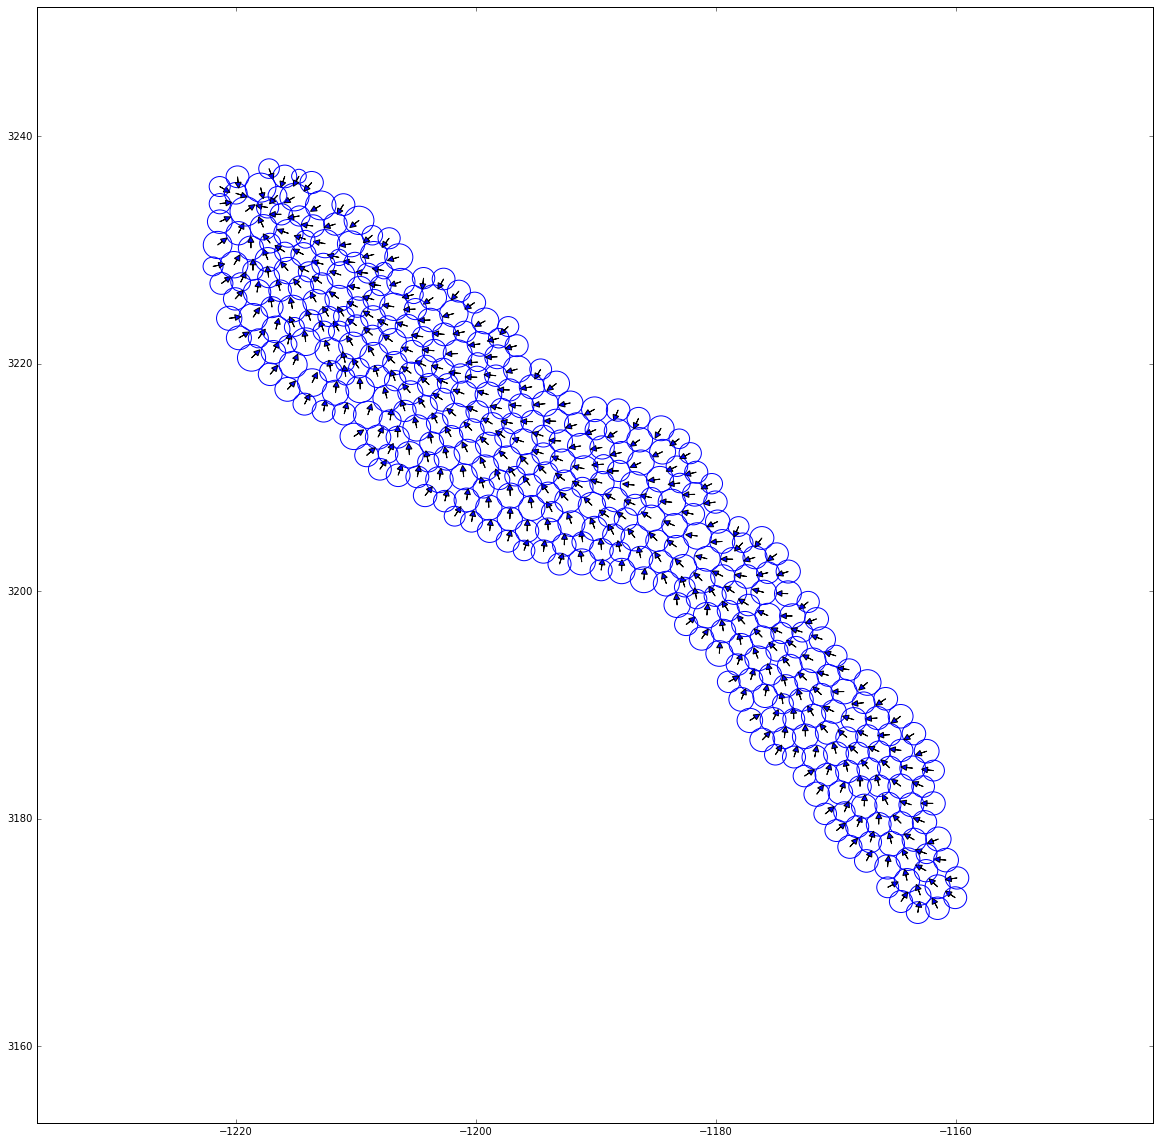

In [8]:
## Visulaization
fig = plt.figure(figsize=(20,20))
ax = plt.gca();
for i in range(Location.shape[0]):
    circle = plt.Circle((Location[i,0], Location[i,1]), Radius[i], color='b', fill=False)
    ax.add_artist(circle);
    ax.arrow(
        Location[i,0],
        Location[i,1],
        0.5 * np.cos(Orientation[i]),
        0.5 * np.sin(Orientation[i]),
        head_width = 0.5,
        head_length = 0.5
    )
a = 1.5;
xd = np.mean(Location[:,0]) - np.abs(np.mean(Location[:,0]) - np.min(Location[:,0])) * a
xu = np.mean(Location[:,0]) + np.abs(np.mean(Location[:,0]) - np.max(Location[:,0])) * a
yd = np.mean(Location[:,1]) - np.abs(np.mean(Location[:,1]) - np.min(Location[:,1])) * a
yu = np.mean(Location[:,1]) + np.abs(np.mean(Location[:,1]) - np.max(Location[:,1])) * a

ax.set_xlim(xd, xu)
ax.set_ylim(yd, yu)
plt.show()

In [6]:
print(np.mean(np.abs(Velocity)))

0.030612782989


In [7]:
np.savez("output.npz", 
         SaveLocation=SaveLocation,
         SaveOrientation=SaveOrientation,
         TimeStep=TimeStep,
         L_align=L_align,
         L_noise=L_noise,
         L_F_in=L_F_in,
         L_T_in=L_T_in,
         L_self=L_self,
         Radius=Radius
        )